# The Impact of Weather in the Coronavirus Spread

<img src="img/coronavirus-weather-hero.jpg">

The World stopped and the fear is around any corner of the planet, everybody speaks about the same and the humans seem powerless in front of a microscopic enemy. With more than 775 748 peoples infected and 37109 deaths (03/30/2020) and with a significative decrease of usual human activity, the COVID-19 will be remembered as a sad part of mankind's history.

I, like many others, am trying to keep doing what I love to do and avoid get crazy thinking about the impact of this crisis in my family and people around the World. I am not a politician, I don't have any kind of power, unfortunately, I'm not a doctor or nurse, and even when I have some ideas and hypotheses about what could be done to get through this crisis (as any other person), I only have my family and potentially my group of 50 friends in Facebook to share it. But, at the same time, I feel that I need to do something else, and for that reason, I began this project as a modest contribution of what I think could be some interesting open questions about the COVID-19.

These are questions:
1. Is there is a relationship between the coronavirus spread and the weather?
2. Is there any difference in the number of deaths and recoveries by gender between countries?
3. Is there a relationship between the number of cases and population density in the US?

## Relationship between the coronavirus spread and the weather

This question is one of the [5 tasks available in Kaggle](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset/tasks?taskId=62) about the COVID-19. For this question, I am going to use different datasets:
1. The first 4 were obtained from Kaggle: 
    1. "[covid_19_data.csv](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#covid_19_data.csv)": Relates the total number of confirmed, deaths and recovered cases per day, Province/State and Country/Region.
    2. "[time_series_covid_19_confirmed.csv](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#time_series_covid_19_confirmed.csv)": Time series data on number of confirmed cases.
    3. "[time_series_covid_19_deaths.csv](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#time_series_covid_19_deaths.csv)": Time series data on number of deaths.
    4. "[time_series_covid_19_recovered.csv](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#time_series_covid_19_recovered.csv)": Time series data on number of recovered cases.
2. The weather datasets (5) were obtained from ["Weather Underground"](https://www.wunderground.com/).      



In [442]:
# Load libraries
import pandas as pd
import numpy as np
# Use the "glob" module to extract pathnames matching a specified pattern
import glob
import calendar
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import mannwhitneyu

In [2]:
# Load the covid_19_data dataset 
covid_2019=pd.read_csv("novel-corona-virus-2019-dataset/covid_19_data.csv")
covid_2019.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [3]:
# List the data feature types
covid_2019.dtypes

SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object

In [4]:
## Transform the data type to the correct format
# 'Last Update' and 'ObservationDate' to datetime
covid_2019['Last Update']=pd.to_datetime(covid_2019['Last Update'])
covid_2019['ObservationDate']=pd.to_datetime(covid_2019['ObservationDate'])
# 'Confirmed','Deaths','Recovered' to int
covid_2019[['Confirmed','Deaths','Recovered']]=covid_2019[['Confirmed','Deaths','Recovered']].astype('int')
# 
covid_2019[['Province/State','Country/Region']]=covid_2019[['Province/State','Country/Region']].astype('category')
covid_2019.dtypes

SNo                         int64
ObservationDate    datetime64[ns]
Province/State           category
Country/Region           category
Last Update        datetime64[ns]
Confirmed                   int64
Deaths                      int64
Recovered                   int64
dtype: object

### Cities Selection
For this study I considered the weather in the last 4 months (December 1 to March 29) of 9 differents cities. The selection criterion was:
* Include the most infected city of the 3 countries with more cases. At 30/03/2020 these countries were US, Italy, and Spain, and the cities were "New York" (US), the region of "Lombardia" in Italy (in this case we selected Milan, which is the capital of Lombardia), and Madrid (Spain) (see details in the subsection [Most infected city of the 3 countries with more cases](#sec:most_infected_cities)).
* Include the city with a greater number of cases for the 3 coldest countries. The list with the coldest countries in the World was obtained from [here](https://www.swedishnomad.com/coldest-countries-in-the-world/) taking into account the average yearly temperature. 
    * The results show that the coldest countries with more cases are "Austria", "Norway", and "Sweden" with 9618, 4445 and 4028 cases respectively. For these countries the most afected cities are Vienna (Austria's capital), Oslo (Norway's capital) and Stockholm (Sweden's capital). For details, see the subsection [Cities in Coldest-Countries](sec:coldest_countries). 
* Include the city with a greater number of cases for the 3 hottest countries. A list with the 15 hottest countries given the average yearly temperature was obtained from [here](https://www.swedishnomad.com/hottest-countries-in-the-world/). 
    * Given these selection parameters, I obtained that the hottest 3 countries with the greatest number of cases are Qatar, United Arab Emirates and Burkina Faso with 693, 611 and 246 cases respectively. I can't found a free access to the weather data of Burkina Faso and as consequence I pick the next country in the list, which is Senegal with 162 cases. The historic weather in the capitals of these 3 countries (Doha, Dubai, Dakar) were selected for this analysis (see details in the subsection [Cities in Hottest-Countries](#sec:hottest_countries)).


> Unfortunately, it was very difficult for me to find accurate information about the weather by country/cities in the last 4 months. All the webpages sell this information (and is very expensive by the way), so, I created and curated manually this data. If anybody has or knows where to obtain this kind of data easily, please, share this information.

#### Most infected city of the 3 countries with more cases
<a id='sec:most_infected_cities'></a>

In [5]:
# Extract the data of the last day
covid_2019_lastDay=covid_2019.loc[covid_2019['ObservationDate']==max(covid_2019['ObservationDate']),:]
covid_2019_lastDay.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
11299,11300,2020-04-03,NaN,Afghanistan,2020-04-03 22:52:45,281,6,10
11300,11301,2020-04-03,NaN,Albania,2020-04-03 22:52:45,304,17,89
11301,11302,2020-04-03,NaN,Algeria,2020-04-03 22:52:45,1171,105,62
11302,11303,2020-04-03,NaN,Andorra,2020-04-03 22:52:45,439,16,16
11303,11304,2020-04-03,NaN,Angola,2020-04-03 22:52:45,8,2,1


In [6]:
# Compute the number total cases by country
cases_by_countries=covid_2019_lastDay.pivot_table(index=['Country/Region'],
                                                  values='Confirmed',
                                                  aggfunc='sum').sort_values(by='Confirmed',
                                                                             ascending=False)
print('The countries with more cases are:\n {}'.format(cases_by_countries.head()))

The countries with more cases are:
                 Confirmed
Country/Region           
US                 275586
Italy              119827
Spain              119199
Germany             91159
Mainland China      81623


In [7]:
# Select the city with more cases for each of the first 3 countries.
countries=['US', 'Italy','Spain']
function = lambda country: covid_2019_lastDay.loc[covid_2019_lastDay['Country/Region']==country,:].sort_values(by='Confirmed',
                                                                             ascending=False).iloc[0,[2,5]]

result={country: list(function(country)) for country in countries}
print('The cities with more cases for each of the top countries are:\n {}'.format(pd.DataFrame(result)))

The cities with more cases for each of the top countries are:
          US     Italy     Spain
0  New York       NaN       NaN
1    102987  119827.0  119199.0


We can see here something unexpected (wasn't obtained any city for Italy or Spain). Let's see what happened:

In [8]:
# Slice the dataset to show only the information relative to Italy 
covid_2019.loc[covid_2019['Country/Region']=='Italy',:].sort_values(by='Confirmed',
                                                                             ascending=False).head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
11379,11380,2020-04-03,NaN,Italy,2020-04-03 22:52:45,119827,14681,19758
11064,11065,2020-04-02,NaN,Italy,2020-04-02 23:32:01,115242,13915,18278
10751,10752,2020-04-01,NaN,Italy,2020-04-01 22:04:58,110574,13155,16847
10438,10439,2020-03-31,NaN,Italy,2020-03-31 23:49:27,105792,12428,15729
10125,10126,2020-03-30,NaN,Italy,2020-03-30 22:58:55,101739,11591,14620


The problem seems to be clear, and it's that our dataset doesn't contain the information of Italy or Spain segmented by regions or provinces (note that only exists one record per day). Fortunately, in the case of Italy, this inconvenience can be overcome using another available [dataset in Kaggle that contain specific information about Italy](https://www.kaggle.com/sudalairajkumar/covid19-in-italy#covid19_italy_region.csv). Therefore, I decided to drop all the information relative to Italy from the `covid_2019` dataset and include the new information available in the Italy dataset.

In [9]:
# Drop all the information relative  to Italy from "covid_2019"
covid_2019=covid_2019.loc[covid_2019['Country/Region']!='Italy',:]
# Check that the information was droped
covid_2019.loc[covid_2019['Country/Region']=='Italy',:]

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered


In [10]:
# Load the new dataframe with the information about Italy
italy=pd.read_csv("novel-corona-virus-2019-dataset/covid19_italy_region.csv")
# print the columns in this dataframe
italy.columns

Index(['SNo', 'Date', 'Country', 'RegionCode', 'RegionName', 'Latitude',
       'Longitude', 'HospitalizedPatients', 'IntensiveCarePatients',
       'TotalHospitalizedPatients', 'HomeConfinement', 'CurrentPositiveCases',
       'NewPositiveCases', 'Recovered', 'Deaths', 'TotalPositiveCases',
       'TestsPerformed'],
      dtype='object')

If we look at the columns of the `italy` dataframme, shows up that the features that  we need to concat the `covid_2019` dataframe and the new one are: `Sno`, `Country`, `Date`, `Recovered`, `Deaths`, `TotalPositiveCases`.

In [11]:
# Create a new dataframe for Italy with only the necesary variables (listed above)
italy=italy[['SNo','Date','RegionName','Country','Date','TotalPositiveCases','Deaths','Recovered']]
italy.columns=['SNo','ObservationDate','Province/State','Country/Region','Last Update',
               'Confirmed','Deaths','Recovered']

In [12]:
# Concat the two dataframes
covid_2019=pd.concat([covid_2019,italy])
# Rename ITA for Italy
covid_2019['Country/Region'].replace(to_replace='ITA',value='Italy',inplace=True)
covid_2019.loc[covid_2019['Country/Region']=='Italy',:].head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,0,2020-02-24T18:00:00,Abruzzo,Italy,2020-02-24T18:00:00,0,0,0
1,1,2020-02-24T18:00:00,Basilicata,Italy,2020-02-24T18:00:00,0,0,0
2,2,2020-02-24T18:00:00,P.A. Bolzano,Italy,2020-02-24T18:00:00,0,0,0
3,3,2020-02-24T18:00:00,Calabria,Italy,2020-02-24T18:00:00,0,0,0
4,4,2020-02-24T18:00:00,Campania,Italy,2020-02-24T18:00:00,0,0,0


I don't found detailed information on the number of cases in Spain by region, but, we know that the greatest number of cases are in Madrid, so, I'm going to pick the information about the weather in Madrid for this analysis.   
Finally, the functions `transform_dtypes` and `cases_country_city` available in the `functions.py` script runs all the steps that we did earlier in [this subsection](#sec:most_infected_cities). The results shows that at this moment New York is US's city with more cases ($\approx 66663$), while the region of Lombardia in Italy has $\approx 42161$ cases.

In [13]:
covid_2019

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22 00:00:00,Anhui,Mainland China,2020-01-22 17:00:00,1,0,0
1,2,2020-01-22 00:00:00,Beijing,Mainland China,2020-01-22 17:00:00,14,0,0
2,3,2020-01-22 00:00:00,Chongqing,Mainland China,2020-01-22 17:00:00,6,0,0
3,4,2020-01-22 00:00:00,Fujian,Mainland China,2020-01-22 17:00:00,1,0,0
4,5,2020-01-22 00:00:00,Gansu,Mainland China,2020-01-22 17:00:00,0,0,0
...,...,...,...,...,...,...,...,...
835,835,2020-04-03T17:00:00,Toscana,Italy,2020-04-03T17:00:00,5499,290,300
836,836,2020-04-03T17:00:00,P.A. Trento,Italy,2020-04-03T17:00:00,2109,204,246
837,837,2020-04-03T17:00:00,Umbria,Italy,2020-04-03T17:00:00,1179,39,220
838,838,2020-04-03T17:00:00,Valle d'Aosta,Italy,2020-04-03T17:00:00,719,70,89


In [14]:
from functions import transform_dtypes, cases_country_city
# Transform data types
covid_2019=transform_dtypes(covid_2019)
# Extract the information about the cities with more cases
_ , cities=cases_country_city(covid_2019)
cities

{'US': ['New York', 102987],
 'Italy': ['Lombardia', 47520],
 'Spain': [nan, 119199]}

#### Cities in Coldest-Countries
<a id='sec:coldest_countries'></a>

In [15]:
# List the names of the coldest countries
coldest_countries=['Canada','Russia','Mongolia','Greenland','Sweden','Norway','Finland','Iceland','Austria']
# Pick only the information of the countries in "coldest_countries" with more than 1000 cases
ind=(covid_2019_lastDay['Country/Region'].isin(set(coldest_countries))) & (covid_2019_lastDay['Confirmed']>1000)
# Subset and sort the dataframe using the number of confirmed cases
covid_2019_lastDay.loc[ind,:].sort_values('Confirmed',ascending=False)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
11307,11308,2020-04-03,NaN,Austria,2020-04-03 22:52:45,11524,168,2022
11454,11455,2020-04-03,NaN,Sweden,2020-04-03 22:52:45,6131,358,205
11576,11577,2020-04-03,Quebec,Canada,2020-04-03 22:52:45,6101,61,0
11421,11422,2020-04-03,NaN,Norway,2020-04-03 22:52:45,5370,59,32
11433,11434,2020-04-03,NaN,Russia,2020-04-03 22:52:45,4149,34,281
11570,11571,2020-04-03,Ontario,Canada,2020-04-03 22:52:45,3255,67,0
11355,11356,2020-04-03,NaN,Finland,2020-04-03 22:52:45,1615,20,300
11372,11373,2020-04-03,NaN,Iceland,2020-04-03 22:52:45,1364,4,309
11488,11489,2020-04-03,British Columbia,Canada,2020-04-03 22:52:45,1174,31,0


#### Cities in Hottest-Countries
<a id='sec:hottest_countries'></a>

In [16]:
# List of hottest countries 
hottest_countries=['Mali','Burkina Faso','Senegal','Mauritania','Djibouti','Benin','Ghana','Niger',
                  'Cambodia','South Sudan','Qatar','United Arab Emirates','Sudan',
                  'Saint Vincent and the Grenadines','Togo']
# Pick only the information of the countries in "hottest_countries"
ind=(covid_2019_lastDay['Country/Region'].isin(set(hottest_countries)))
# Subset and sort the dataframe using the number of confirmed cases
covid_2019_lastDay.loc[ind,:].sort_values('Confirmed',ascending=False).head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
11468,11469,2020-04-03,NaN,United Arab Emirates,2020-04-03 22:52:45,1264,9,108
11431,11432,2020-04-03,NaN,Qatar,2020-04-03 22:52:45,1075,3,93
11324,11325,2020-04-03,NaN,Burkina Faso,2020-04-03 22:52:45,302,16,50
11440,11441,2020-04-03,NaN,Senegal,2020-04-03 22:52:45,207,1,66
11361,11362,2020-04-03,NaN,Ghana,2020-04-03 22:52:45,205,5,31


### Historical weather data
<a id='sec:historical_weather_data'></a>

The historical weather of the selected 9 cities was collected from ["Weather Underground"](https://www.wunderground.com/) and saved in independents CSV files (one file per city). Each file contains information about the weather from December 2019 to March 30, 2020 (121 observations), condensed into 18 variables: 

| Variable                                     | Description                                       |
|:----------------------------------------------|:---------------------------------------------------|
| Day                                          | Day                                               |
| Month                                        | Month                                             |
| Year                                         | Year                                              |
| Country                                      | Name of the country                               |
| State                                        | Name of the state or region                       |
| TempMax/TempAvg/TempMin                      | Maximum, average and minimum temperature ($^o F$) |
| HumMax/HumAvg/HumMin                         | Maximum, average and minimum humidity (%)         |
| Wind_Speed_Max/Wind_Speed_Avg/Wind_Speed_Min | Maximum, average and minimum wind speed (mph)     |
| Pressure_Max/Pressure_Avg/Pressure_Min       | Maximum, average and minimum pressure (Hg)        |
| Total_Precipitations                         | Total precipitations (in)                         |



Below you can take a look at this information in the case of New York.

In [17]:
weather_NewYork=pd.read_csv("Weather/NewYork_December2019_March_2020.csv")
print('This dataset is composed by {} observations and {} variables.'.format(weather_NewYork.shape[0],
                                                                            weather_NewYork.shape[1]))
weather_NewYork.head()

This dataset is composed by 121 observations and 18 variables.


,Day,Month,Year,Country,State,TempMax,TempAvg,TempMin,HumMax,HumAvg,HumMin,Wind_Speed_Max,Wind_Speed_Avg,Wind_Speed_Min,Pressure_Max,Pressure_Avg,Pressure_Min,Total_Precipitations
0,1,December,2019,USA,New York,40,35.2,30,93,75.7,42,31,18.2,7,30.0,29.8,29.5,0.00
1,2,December,2019,USA,New York,39,35.7,32,89,86.1,82,28,17.7,9,29.5,29.5,29.5,0.62
2,3,December,2019,USA,New York,38,33.9,32,85,69.7,54,29,18.3,10,29.6,29.5,29.5,0.34
3,4,December,2019,USA,New York,40,38.1,34,76,68.4,63,16,10.7,6,29.6,29.5,29.5,0.00
4,5,December,2019,USA,New York,43,39.9,38,76,57.5,40,24,16.0,9,30.1,29.8,29.5,0.00


The next step is to merge the information in all these 9 files in only one.

In [284]:
# Extract the directories
directories=glob.glob("/home/yasel/Data Science/Projects/Coronavirus/Weather/*.csv")
# Create an empty dataframe to store the information
weather=pd.DataFrame()
# Include the new data in "weather" for each csv file in the directory
for file in directories:
    this_data=pd.read_csv(file)
    weather=pd.concat([weather,this_data],axis=0)
weather.head()

,Day,Month,Year,Country,State,TempMax,TempAvg,TempMin,HumMax,HumAvg,HumMin,Wind_Speed_Max,Wind_Speed_Avg,Wind_Speed_Min,Pressure_Max,Pressure_Avg,Pressure_Min,Total_Precipitations
0,1,December,2019,Austria,Vienna,39,33.7,27,93,80.8,65,22,12.9,3,29.6,29.5,29.4,0.0
1,2,December,2019,Austria,Vienna,39,35.8,32,100,81.5,61,20,11.8,2,29.6,29.5,29.4,0.0
2,3,December,2019,Austria,Vienna,41,36.0,27,93,70.4,53,17,10.3,1,29.7,29.7,29.6,0.0
3,4,December,2019,Austria,Vienna,37,29.7,25,93,85.6,65,24,13.3,3,29.7,29.7,29.6,0.0
4,5,December,2019,Austria,Vienna,32,30.0,28,93,83.9,75,28,17.3,8,29.7,29.6,29.6,0.0


Above, you can see that the `months` appear as a `string`, probably will be better to transform this variable to `int`.

In [285]:
# Create a dictionary with the names of the months and the number that represent it.
d = dict((v,k) for k,v in enumerate(calendar.month_name))
# Replace the variable 'Month' using the dictionary
weather['Month']=weather['Month'].map(d)
weather.head()

,Day,Month,Year,Country,State,TempMax,TempAvg,TempMin,HumMax,HumAvg,HumMin,Wind_Speed_Max,Wind_Speed_Avg,Wind_Speed_Min,Pressure_Max,Pressure_Avg,Pressure_Min,Total_Precipitations
0,1,12,2019,Austria,Vienna,39,33.7,27,93,80.8,65,22,12.9,3,29.6,29.5,29.4,0.0
1,2,12,2019,Austria,Vienna,39,35.8,32,100,81.5,61,20,11.8,2,29.6,29.5,29.4,0.0
2,3,12,2019,Austria,Vienna,41,36.0,27,93,70.4,53,17,10.3,1,29.7,29.7,29.6,0.0
3,4,12,2019,Austria,Vienna,37,29.7,25,93,85.6,65,24,13.3,3,29.7,29.7,29.6,0.0
4,5,12,2019,Austria,Vienna,32,30.0,28,93,83.9,75,28,17.3,8,29.7,29.6,29.6,0.0


In [286]:
# Include a new variable called "Infection Day" with the date (note that I name this variable as in the case 
# of the covid dataframe to make clear that I am going the merge this dataframes using this variable)
weather['Infection Day']=pd.to_datetime(weather[['Year', 'Month', 'Day']]).dt.date
# Drop the information relative to the Day, Month and Year
weather.drop(columns=['Day','Month','Year'],inplace=True)
# Convert the 'Country' and 'State' features from objects to category variables
weather[['Country','State']]=weather[['Country','State']].astype('category')
weather.head()

,Country,State,TempMax,TempAvg,TempMin,HumMax,HumAvg,HumMin,Wind_Speed_Max,Wind_Speed_Avg,Wind_Speed_Min,Pressure_Max,Pressure_Avg,Pressure_Min,Total_Precipitations,Infection Day
0,Austria,Vienna,39,33.7,27,93,80.8,65,22,12.9,3,29.6,29.5,29.4,0.0,2019-12-01
1,Austria,Vienna,39,35.8,32,100,81.5,61,20,11.8,2,29.6,29.5,29.4,0.0,2019-12-02
2,Austria,Vienna,41,36.0,27,93,70.4,53,17,10.3,1,29.7,29.7,29.6,0.0,2019-12-03
3,Austria,Vienna,37,29.7,25,93,85.6,65,24,13.3,3,29.7,29.7,29.6,0.0,2019-12-04
4,Austria,Vienna,32,30.0,28,93,83.9,75,28,17.3,8,29.7,29.6,29.6,0.0,2019-12-05


In [292]:
# Print some basic exploration statistics
print('The dataframe with all the weather information is composed by {} rows and {} columns.'.format(weather.shape[0],
                                                                                                   weather.shape[1]))
print('The countries included in this dataframe are:\n {}'.format(weather['Country'].unique()))
print('The cities included in this dataframe are:\n {}'.format(weather['State'].unique()))
print('The total number of Missing Values are: {}'.format(weather.isna().sum().sum()))

The dataframe with all the weather information is composed by 1218 rows and 16 columns.
The countries included in this dataframe are:
 [Austria, USA, United Arab Emirates, Qatar, Senegal, Sweden, Norway, Spain, Italy, Canada]
Categories (10, object): [Austria, USA, United Arab Emirates, Qatar, ..., Norway, Spain, Italy, Canada]
The cities included in this dataframe are:
 [Vienna, New York, Dubai, Doha, Dakar, Stockholm, Oslo, Madrid, Lombardia, Quebec]
Categories (10, object): [Vienna, New York, Dubai, Doha, ..., Oslo, Madrid, Lombardia, Quebec]
The total number of Missing Values are: 0


> So far, the weather information looks nice, so, we can move forward and try to relate the covid 2019 dataset with this new weather information.

### Weather and Infected people by day
<a id='sec:weather_and_infected_people_by_day'></a>
At this point it's important to structure the dataset based on some previous assumptions:
   1. We are only considering 7 cities to study the relationship of the disease with the weather. 
   2. If a person "X" was reported as infected at the day "D", then the exposure occurred [between 2-14 days before](https://www.cdc.gov/coronavirus/2019-ncov/symptoms-testing/symptoms.html). I am going to assume here that the mean of persons with the disease has the first symptoms on day 8 (the mean point between 2 and 14) after exposure. This is, the weather that matter in the infection of "X" is the weather in the day ("D" - 8).
       > I am assuming that the weather doesn't matter once the virus gets into a person (which for me seems logical).

In accordance with the first point above, let's extract from our general data the information about these 7 cities/countries. Here it's important to remember that our dataset has the information of some countries segmented by cities (e.g. US, Italy), but others (like Spain, Austria) only have country-level data, so, the first step is to complete the missing information in the `Province/State` feature. 

In [293]:
# Filter only the observations of the selected countries
selected_countries=['US','Italy','Austria', 'Canada', 'Sweden', 'Qatar', 
                    'United Arab Emirates', 'Senegal', 'Spain']
covid_2019_countries=covid_2019.loc[covid_2019['Country/Region'].isin(selected_countries),:].copy()

# Include the cities in the selected countries without city level information
countries_without_cities={'Austria': 'Vienna', 'Sweden': 'Stockholm',
                          'Qatar': 'Doha', 'United Arab Emirates': 'Dubai', 
                          'Senegal': 'Dakar', 'Spain':'Madrid'}
covid_2019_countries.loc[:,'Province/State'] = covid_2019_countries.apply(
    lambda row: countries_without_cities[row['Country/Region']] if 
    row['Country/Region'] in countries_without_cities.keys() else row['Province/State'],
    axis=1
)
# Check that we don't have missing information in the "Province/State" feature
print('The number of missing values in the Province/State feature is: {} ---> Great!!'.format(covid_2019_countries['Province/State'].isna().sum()))

The number of missing values in the Province/State feature is: 0 ---> Great!!


In [294]:
# Now, it's time to select only the information relative to the cities
cities=['New York','Madrid','Quebec','Lombardia','Vienna','Stockholm',
       'Doha','Dubai','Dakar']
covid_final=covid_2019_countries.loc[covid_2019_countries['Province/State'].isin(cities),:].copy()
print('The cities available in the reduced dataframe are:\n {} ==> Nice, everything looks fine'.format(covid_final['Province/State'].unique()))
print('The countries available in the reduced dataframe are:\n {} ==> Nice!'.format(list(covid_final['Country/Region'].unique())))
print('So far, the information about the cities of interests is contained in {} rows and {} columns.'.format(covid_final.shape[0],covid_final.shape[1]))
print('The new dataset has {} missing values'.format(covid_final.isna().sum().sum()))
covid_final.head()

The cities available in the reduced dataframe are:
 ['Dubai' 'Stockholm' 'Madrid' 'Vienna' 'Doha' 'Dakar' 'Quebec' 'New York'
 'Lombardia'] ==> Nice, everything looks fine
The countries available in the reduced dataframe are:
 ['United Arab Emirates', 'Sweden', 'Spain', 'Austria', 'Qatar', 'Senegal', 'Canada', 'US', 'Italy'] ==> Nice!
So far, the information about the cities of interests is contained in 391 rows and 8 columns.
The new dataset has 0 missing values


,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
372,373,2020-01-29,Dubai,United Arab Emirates,2020-01-29 19:30:00,4,0,0
428,429,2020-01-30,Dubai,United Arab Emirates,2020-01-30 16:00:00,4,0,0
473,474,2020-01-31,Dubai,United Arab Emirates,2020-01-31 23:59:00,4,0,0
492,493,2020-01-31,Stockholm,Sweden,2020-01-31 23:59:00,1,0,0
536,537,2020-02-01,Dubai,United Arab Emirates,2020-01-31 08:15:00,4,0,0


The first task described at the [beginning of this section](#sec:weather_and_infected_people_by_day) is done, so now we need to move forward to the second point. Remember, for this, we need to compute the number of new cases by day and city (now our dataset contains the accumulative number of cases), and next we need to move back the dates in 8 days (see [above](#sec:weather_and_infected_people_by_day) for more details).

Also, I am going to create a new variable (`Days Since First Case`) that represents the number of days since the first infection case was reported in a city. Note that this variable could give more direct information about the number of new cases per day after the first infection.

In [302]:
# The number of new cases in the day (N_d) can be computed as [N_d - N_(d-1)]. 
# Remember that we need to do this by city.
# Iterate ove the cities and compute the number of new cases per day
covid_new_cases=pd.DataFrame()
for city in cities:
    # Subset the dataset to considder only one city
    temp=covid_final.loc[covid_final['Province/State']==city,:].sort_values(by='ObservationDate')
    # Compute the subtractin for all the days except for the first one and storage the results in 
    # the column "ObservationDate"
    temp.loc[temp['ObservationDate']>min(temp['ObservationDate']),
             'Confirmed'] = temp['Confirmed'][1:].values - temp['Confirmed'][:-1].values
    
    # Compute the subtractin of all days since the first one 
    days=temp.loc[0:,'ObservationDate'].values - temp.iloc[0,1]
    temp['Days Since First Case'] =[tt.days for tt in days]
    
    # Concatenate the result with the "covid_new_cases" dataframe
    covid_new_cases=pd.concat([covid_new_cases,temp])
# Print a piece of "covid_new_cases" dataframe
covid_new_cases.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Days Since First Case
4549,4550,2020-03-10,New York,US,2020-03-10 17:13:27,173,0,0,0
4755,4756,2020-03-11,New York,US,2020-03-11 22:53:03,47,0,0,1
4964,4965,2020-03-12,New York,US,2020-03-12 21:39:10,108,0,0,2
5356,5357,2020-03-13,New York,US,2020-03-11 20:00:00,93,0,0,3
5411,5412,2020-03-14,New York,US,2020-03-14 22:13:32,104,2,0,4


Above, we can see that the number of confirmed cases is no longer a cumulative variable. But given that this variable is very important for this project, let's be more cautious and confirm that everything looks as we want after the transformation. For this, let's compute the sum of all the new cases by city and compare the result with the number of cases the last day in the original data frame.

In [297]:
# Resume in test1 the sum of the new cases by cities
test1=covid_new_cases.pivot_table(index=['Province/State'],values='Confirmed',aggfunc='sum')
# Extract in test2 the number of cases the last day
test2=covid_final.loc[covid_final['ObservationDate']==max(covid_final['ObservationDate']),['Province/State','Confirmed']]
# Merge and show this information
pd.merge(test1,test2,on='Province/State',suffixes=('_cumulative (Last Day)', '_sum (new cases per day)'))

,Province/State,Confirmed_cumulative (Last Day),Confirmed_sum (new cases per day)
0,Dakar,207,207
1,Doha,1075,1075
2,Dubai,1264,1264
3,Lombardia,47520,47520
4,Madrid,119199,119199
5,New York,102987,102987
6,Quebec,6101,6101
7,Stockholm,6131,6131
8,Vienna,11524,11524


As we can see in the above table, everything looks good and only remain to move the dates 8 days back in the calendar as an approximation of when the infection occurred. For this, I am going to include a new variable called `Infection Day`.

In [298]:
# Estimate the infection day
covid_new_cases['Infection Day']=covid_new_cases['ObservationDate'] -  pd.to_timedelta(8,'d')
# Shows the new results
covid_new_cases.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Days Since First Case,Infection Day
4549,4550,2020-03-10,New York,US,2020-03-10 17:13:27,173,0,0,0,2020-03-02
4755,4756,2020-03-11,New York,US,2020-03-11 22:53:03,47,0,0,1,2020-03-03
4964,4965,2020-03-12,New York,US,2020-03-12 21:39:10,108,0,0,2,2020-03-04
5356,5357,2020-03-13,New York,US,2020-03-11 20:00:00,93,0,0,3,2020-03-05
5411,5412,2020-03-14,New York,US,2020-03-14 22:13:32,104,2,0,4,2020-03-06


At this moment, we covered the two points described at the beginning of [this section](#sec:weather_and_infected_people_by_day) and only remain to merge the information in the coronavirus dataset ("covid_new_cases") with the weather dataset "weather". Note that we need to do a left join (complete the  information in the "covid_new_cases" dataset with the weather).

In [299]:
# Left Join the two data frames
covid_weather=pd.merge(covid_new_cases,weather,how='left',left_on=['Infection Day','Province/State'],
                                            right_on=['Infection Day','State'])
# Some variables like SNo, State (is a duplication of "Province/State"), 
# Country (is a duplication of "Country/Region") or "LastUpdate" are not 
# necessary to this study, so let's drop it from the data.
covid_weather.drop(columns=['SNo','State','Country','Last Update'],inplace=True)
covid_weather.head()

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered,Days Since First Case,Infection Day,TempMax,TempAvg,TempMin,HumMax,HumAvg,HumMin,Wind_Speed_Max,Wind_Speed_Avg,Wind_Speed_Min,Pressure_Max,Pressure_Avg,Pressure_Min,Total_Precipitations
0,2020-03-10,New York,US,173,0,0,0,2020-03-02,56,48.2,38,73,51.1,35,16,10.3,5,30.1,29.9,29.8,0.00
1,2020-03-11,New York,US,47,0,0,1,2020-03-03,58,52.4,48,89,75.5,53,26,10.1,0,29.8,29.6,29.4,0.01
2,2020-03-12,New York,US,108,0,0,2,2020-03-04,57,50.5,46,66,44.8,24,28,18.2,12,29.9,29.7,29.5,0.28
3,2020-03-13,New York,US,93,0,0,3,2020-03-05,52,44.8,40,71,48.5,27,24,12.9,5,30.1,30.1,29.9,0.00
4,2020-03-14,New York,US,104,2,0,4,2020-03-06,45,41.6,37,89,74.7,65,20,13.0,5,30.1,29.9,29.8,0.00


In [300]:
for city in cities:
    print('The data frames have a {} match between the number of observations in {}'.format(
        covid_weather.loc[covid_weather['Province/State']==city,:].shape[0]==
        covid_new_cases.loc[covid_new_cases['Province/State']==city,:].shape[0],city))
print('The final data frame that condense all the information about the coronavirus disease and the weather in the selected 9 cities has {} observations and {} features.'.
     format(covid_weather.shape[0],covid_weather.shape[1]))
print('The total number of missing values in the data frame is {} ==> Great!!'.format(covid_weather.isna().sum().sum()))

The data frames have a True match between the number of observations in New York
The data frames have a True match between the number of observations in Madrid
The data frames have a True match between the number of observations in Quebec
The data frames have a True match between the number of observations in Lombardia
The data frames have a True match between the number of observations in Vienna
The data frames have a True match between the number of observations in Stockholm
The data frames have a True match between the number of observations in Doha
The data frames have a True match between the number of observations in Dubai
The data frames have a True match between the number of observations in Dakar
The final data frame that condense all the information about the coronavirus disease and the weather in the selected 9 cities has 391 observations and 21 features.
The total number of missing values in the data frame is 0 ==> Great!!


> Finally!!! Our data looks tidy and we are ready to board our scientific questions.

## Coronavirus vs Temperature

For the following analysis is important to remember that the variable `Confirmed` contains the information about the new cases that were infected at `Infection Day`. Note that this is an estimation, but in my opinion is more realistic that study the weather around 8 days after that the infection accour.   

Fig. "_Temperature Avg by Day_" shows the temperature in the 9 `Province/State` since the `Infection Day` of the first reported patient. This time series shows that the hottests `Province/State` (Dakar, Dubai, Doha) have mean temperatures over $\approx 65^o F$ in all days, while Quebec is the only `Province/State` that had under $30^o F$ most of the time. The temperature in all the others `Province/States` were between 30 and $60^o F$.
> Note that this graph shows the possibility to make a discretization of the temperature potentially considering 3 ranges of values. In the future, should be nice to do a k-means analysis with 3 clusters to study the number of cases by the range of temperature (see below).

In [326]:
# PLot the Temperature Avg by day
px.line(covid_weather, x='Infection Day', y='TempAvg', color='Province/State',
       title='Average Temperature by Day')

Now it's time to begin to explore the relationship between the temperature and the number of new cases. Fig. _New Infections vs Temperature_ shows that the greatest number of infections occurs in cities with a mean temperature between $40$ and $60^o F$. This is the case of New York, Madrid, and Lombardia with a median temperature of $47.5^o F$, $50.5^o F$ and $47.75^o F$ respectively.     
Note that for temperatures over $65^o F$ the numbers of infections seems to be very low in comparison with the other regions with lowest temperatures. Also, as we advertise previously, Quebec is the province with the lowest temperature, and also seems to has a low number of new infections in comparison with the regions with temperatures between $40$ and $60^o F$, but more than those regions with high temperatures.
> Even when this is not concluded, we can hypothesize that if the temperature has an impact on the spread of the Coronavirus, then:
1. The spread is reduced significatively when the temperature is over $\approx 65^o F$.
2. It's more probable to have more infections when the temperature varies between $40$ and $60^o F$ approximately.
3. For temperatures under the $\approx 35^o F$, the spread seems to be less than when the temperature is between $40$ and $60^o F$ but greater than for regions with temperatures over $65^o F$. In resume, the cold seems to be a factor that impacts the spread of the virus but less than hight temperatures.

In [349]:
# Scatterplot between the Average Temperature and the number of Cases by Province/State
px.scatter(covid_weather, x="TempAvg", y="Confirmed", color="Province/State",
                 marginal_y=None, marginal_x="box", trendline="o",
          title='New Infections vs Temperature')

As we exposed at the beginning of this section, it could be interesting (and potentially better for visualization) to create 3 clusters using the temperature variable. Probably and given the descriptive and exploratory analysis that we did so far, we know between which ranges the temperature will vary, but I think it's better to use a K-means algorithm to find for us these intervals.

In [354]:
# Import k-means from sklearn
from sklearn.cluster import KMeans
# Extract the information  about the temperatures
X=np.array(covid_weather['TempAvg'])
# Cluster
kmeans = KMeans(n_clusters=3, random_state=0).fit(X.reshape(-1,1))
# Include the labels in our data frame in the variable "Cluster_Temp"
covid_weather['Cluster_Temp']=kmeans.labels_
# Compute the min and max teperatures values in each cluster
covid_weather.pivot_table(index='Cluster_Temp',values='TempAvg',aggfunc=['min','max'])

,min,max
,TempAvg,TempAvg
Cluster_Temp,,
0,40.3,59.3
1,60.3,86.9
2,14.0,39.7


The above table resumes the results of the k-means analysis. The results look very similar to what we expected, note that one of the cluster (cluster #2) groups temperatures under $\approx 40^o F$ while the cluster #1 groups temperatures greater than $60^o F$. Finally, the cluster #0 groups temperatures between $\approx 40$ and $60^o F$.    
Now, let's transform the new variable `Cluster_Temp` to include the ranges of values as labels instead of integer labels than don't provide much information.

In [367]:
dic={0:'40-60 F', 1: '>60 F', 2: '<40 F'}
covid_weather['Cluster_Temp'].replace(dic,inplace=True)
px.scatter(covid_weather, x="TempAvg", y="Cluster_Temp", color="Cluster_Temp",
                 marginal_y=None, marginal_x=None, trendline="o",
          width=900, height=300)

The above discretization allows quantifying the number of infections by temperature ranges. Fig. _Temperature ranges and New Infections_ shows that the number of new infections is around 250 000 across all the `Province/State` when the temperature is between $40$ and $60^o F$, which is significantly higher than the two other ranges. Also, this histogram shows that the number of total new cases when the temperature is under $40^o F$ ($\approx 35 000$) is notably bigger than when the temperature is over the $60^o F$, in which case our data only report around 10 000 new infections.

In [380]:
# Histogram of the number of infections by group of temperature
px.bar(covid_weather, x="Cluster_Temp", y="Confirmed", 
       color="Province/State", title='Temperature ranges and New Infections')

The previous observations are far away to be conclusive because these differences could be explained as a consequence of differents factors like:
* Differences in the population density between Provinces/States (cities with more population are more likely to has more cases).
* Our sample has mostly cities with temperatures between $40-60^o F$.
* Sociocultural factors. Note here that Spanish and Italians are warm people, normally use to have close interpersonal relationships, and as a consequence this power the spread of the virus. The explanation is extensible for New York, which is a very multicultural city.

The table below resumes the total days for each temperature group and `Province/Region`. As we can see, New York is the only city that has days in each of the temperature ranges but isn't enough to even consider a fair statistical comparison of the number of new cases between temperature groups. Without doub, this is a limitation of our dataset, and in my opinion the best bet could be to compare cities with similar population density and different temperatures.
> Note that taking this path, we are assuming that the sociocultural factors are similar between the population of two different cities, which could be a bias, but I need to simplified our analysis because sadly I don't have all the necessary data.

In [423]:
# Number of days that each Province/State had for each range of temperature
covid_weather.pivot_table(index='Province/State',columns='Cluster_Temp',
                          values='Days Since First Case',aggfunc='count')

Cluster_Temp,40-60 F,<40 F,>60 F
Province/State,,,
Dakar,NaN,NaN,33.0
Doha,NaN,NaN,35.0
Dubai,NaN,NaN,66.0
Lombardia,40.0,NaN,NaN
Madrid,61.0,NaN,2.0
New York,21.0,3.0,1.0
Quebec,NaN,26.0,NaN
Stockholm,20.0,44.0,NaN
Vienna,32.0,7.0,NaN


The data about the `Population`, `Land Area` and `Population Density` for each of the `Province/Region` was obtained from [Wikipedia](https://www.wikipedia.org/) and shows in the below table. The good news is that Doha and Dakar are the regions with more population density, but also  the temperature in these regions is always over $60^o F$, so, this open the posibility to compare these regions with the others with other temperatures ranges.

In [421]:
# Create a data frame with the Region/State population and Land Area
region_state_density=pd.DataFrame({'Region/State':['Dakar', 'Doha', 'Dubai',
                             'Lombardia','Madrid','New York',
                             'Quebec','Stockholm','Vienna'], 
              'Population': [2956023,2382000,3331420, 10078012,
                             3223334,19453561,8164361,2377081,1888776 ],
             'Land Area (sq mi)': [211,51,1588,9206,233.3,54555,595391,2517,160.15]})
# Compute the density = Area/population
region_state_density['Population Density']=region_state_density['Population']/region_state_density['Land Area (sq mi)']
region_state_density.sort_values(by=['Population Density'],ascending=False,inplace=True)
region_state_density

,Region/State,Population,Land Area (sq mi),Population Density
1,Doha,2382000,51.00,46705.882353
0,Dakar,2956023,211.00,14009.587678
4,Madrid,3223334,233.30,13816.262323
8,Vienna,1888776,160.15,11793.793319
2,Dubai,3331420,1588.00,2097.871537
3,Lombardia,10078012,9206.00,1094.722138
7,Stockholm,2377081,2517.00,944.410409
5,New York,19453561,54555.00,356.586216
6,Quebec,8164361,595391.00,13.712604


Taking into account that we don't have a lot of information on states with low temperatures and higher population density than such regions or states with temperatures between $40-60^o F$, I decided to compare only the impact of high temperatures in the spread of the virus. For this comparison, I defined the next rules in order to decrease the bias (see points above):
1. I am only going to consider Dakar, Dubai and Doha as the `Province/State` with high temperatures.
2. In order the compare one `Province/State` with one of the above three cities ($X_i$), the population density of the `Province/State` should be less than the population density of $X_i$. With this, we avoid the consideration that the differences between the number of new cases in two different cities are given because of the population's density and not for other factors.

Based on the above rules, I obtained that the comparables provinces/states are:

|           | Dakar | Doha | Dubai |
|-----------|-------|------|-------|
| New York  | ✔️     | ✔️    | ✔️     |
| Madrid    | ✔️     | ✔️    | ✖️     |
| Lombardia | ✔️     | ✔️    | ✔️     |
| Vienna    | ✔️     | ✔️    | ✖️     |
| Stockholm | ✔️     | ✔️    | ✔️     |
| Quebec    | ✔️     | ✔️    | ✔️     |

Our objective is to compare if the distribution of the new infections in two different cities comes from the same population or not. In other words, the null hypothesis is that the spread of the virus is independent of the temperature and the alternative hypothesis is that the spread is lower in cities with high temperatures. 
  
The distributions of the new infections are independent but also are far away from following a normal distribution (see Fig. _Region/State_ below).  Nevertheless, it has been reported that samples with more than 15 observations (there are at least 25 in each of our distributions) are enough to avoid the normality assumption in the case of two samples t-student hypothesis test (see [here](https://support.minitab.com/en-us/minitab/18/Assistant_Two_Sample_t.pdf), or [here](https://books.google.com/books?hl=en&lr=&id=fZZTBgAAQBAJ&oi=fnd&pg=PR7&ots=KVNzlTQZBU&sig=uc2nGPRKmXFRx5q5d627Vf2ndPc#v=onepage&q&f=false), and also [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3693611/)). I am not happy with this number of samples, but, in this case, it's important to make inference over the mean (parametric case) and not over the median (nonparametric case) Why? Because we need to take into account if exists a high number of new infections. Also, the nonparametric tests assume that all groups must have the same or very similar spread (variance), which doesn't seem to be the case in our data. Finally, a parametric test (like t-student) gives more statistical power to the test (less probability to fail to reject the null hypothesis when it is false).

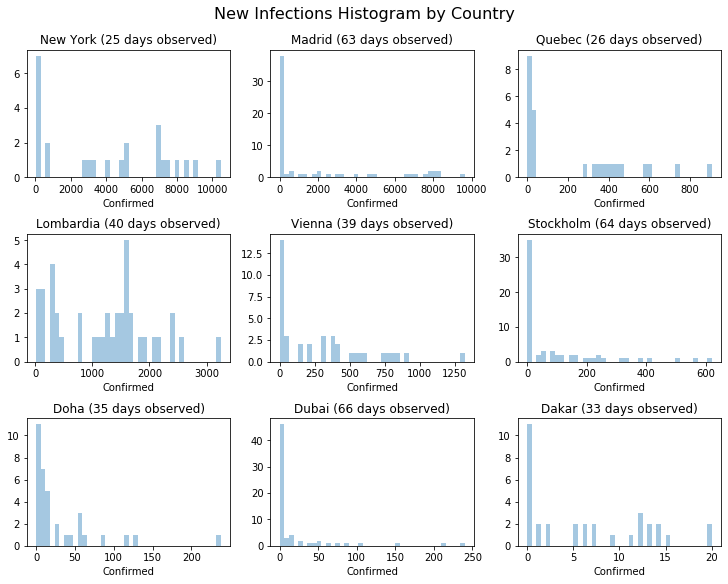

In [441]:
# Histogram of the new cases by cities
fig1, axs = plt.subplots(3, 3, figsize=(10,8), constrained_layout=True)
axs = trim_axs(axs, len(cities))
for ax, city in zip(axs, cities):
    X=covid_weather.loc[covid_weather['Province/State']==city,'Confirmed']
    ax.set_title('{} ({} days observed)'.format(city,len(X)))
    sns.distplot(X,kde=False,ax=ax,bins=40)
fig1.suptitle('New Infections Histogram by Region/State', fontsize=16);

For these tests, I am going to set the critical value $\alpha=0.05$, and establish the length of each sample to the lengh of the sample with less observations. This is, if X, Y are the two samples to compare with length $l_X$ and $l_Y$ respectively, and $\hat{l}=min(l_X,l_Y)$, then I am only two consider the observations of X and Y between the first infection day and the day $\hat{l}$.
> The above could look as tricky, but in fact, it has an easy explanation, and it is that we need to compare the same number of days after the first infection because in the other way we are introducing a bias based on the lack of information in the distribution with fewer observations.

In [534]:
## t-student Hypothesis tests ##
# Create a dictionary with the pairs of cities to be tested
cities2test=dict({'Dakar': ['New York','Madrid','Lombardia','Vienna','Stockholm','Quebec'],
                 'Doha': ['New York','Madrid','Lombardia','Vienna','Stockholm','Quebec'],
                 'Dubai': ['New York','Lombardia','Stockholm','Quebec']})
# Empty dictionary to store the results
results=dict() 
# For each key in the dictionary (cities with high temperature) run the test with each of the values of this key
for hot_city in cities2test.keys():
    paired_cities=cities2test[hot_city] # List with the cities to test with "hot_city"
    # Extract the information of the "hot_city"
    hot_city_values=covid_weather.loc[covid_weather['Province/State']==hot_city,
                                      ['Days Since First Case','Confirmed']].sort_values(by=['Days Since First Case'])
    # Define an empty dictionary to store the partial results 
    partial=dict()
    # Run the test for each pair of cities
    for city in paired_cities:
        # Extract the number of new cases of city
        city_values=covid_weather.loc[covid_weather['Province/State']==city,
                         ['Days Since First Case','Confirmed']].sort_values(by=['Days Since First Case'])
        # Get the max number of observations available in both cities
        max_mutual_obs=min(hot_city_values.shape[0],city_values.shape[0])
        # Store the information in X (key country) and Y (test country)
        X=hot_city_values['Confirmed'][0:max_mutual_obs].values
        Y=city_values['Confirmed'][0:max_mutual_obs].values
        # Run the t-student hypothesis test
        #stat, p = mannwhitneyu(X,Y,alternative='less')
        stat, p = stats.ttest_ind(X, Y,equal_var=False)
        # Save the p-value result in "partial"
        partial[city]=p
    # Include the dictionary with partial results in the general dictionary
    results[hot_city]=partial
# Tranform the dictionary to a dataframe        
results=pd.DataFrame.from_dict(results, orient='columns')
results.style.applymap(color_p_value)

,Dakar,Doha,Dubai
New York,0.000004,0.000004,0.000004
Madrid,0.873063,0.045654,nan
Lombardia,0.000000,0.000000,0.000000
Vienna,0.000188,0.000168,nan
Stockholm,0.000021,0.001936,0.000041
Quebec,0.000206,0.000482,0.000168


* Para densidad de poblacion: https://worldpopulationreview.com/countries/china-population/
* Para el tiempo: https://www.wunderground.com/history/monthly/us/ny/new-york-city/KLGA/date/2019-12
* The world cities document was obtained from: https://simplemaps.com/data/world-cities (this not include the density or region size).
